In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load California housing dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

In [3]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Data info
print(f"Dataset shape: {X.shape}")
print(f"Features: {california.feature_names}")
print(f"Target: Median house value (in $100,000s)")

Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)


In [5]:
# Initialize and train Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

In [6]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [7]:
# Predictions
y_pred = rf.predict(X_test)

In [8]:
# Evaluate
print(f"\nRandom Forest Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")


Random Forest Performance:
R² Score: 0.7886
RMSE: 0.5263


In [9]:
# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

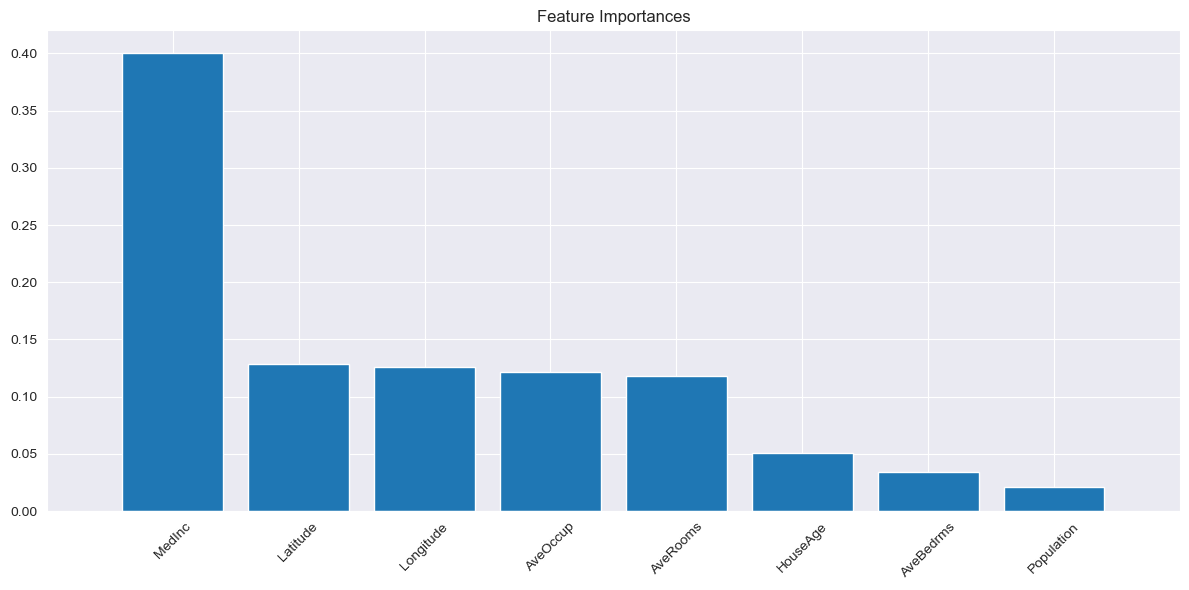

In [10]:
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [11]:
# SHAP values for deeper interpretation
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

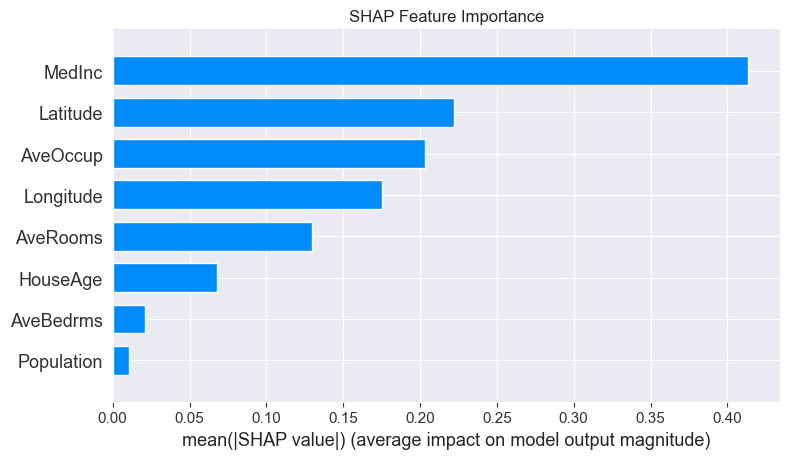

In [12]:
# SHAP Feature Importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

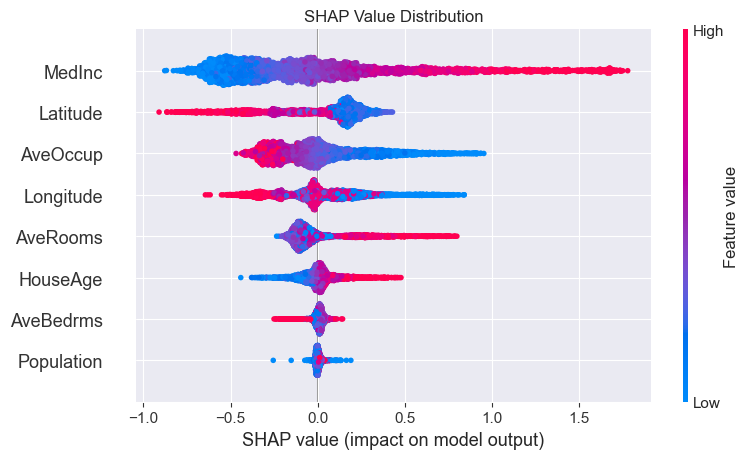

In [13]:
# SHAP Value Distribution
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.show()

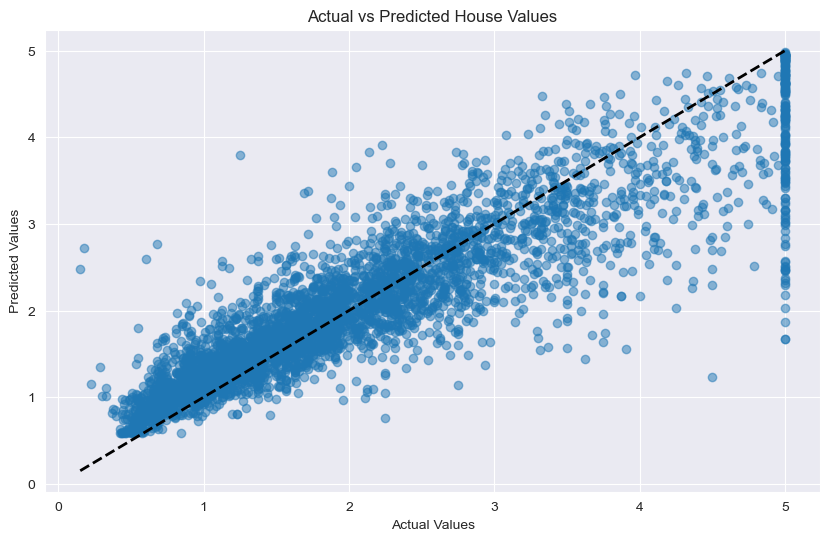

In [14]:
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted House Values')
plt.show()

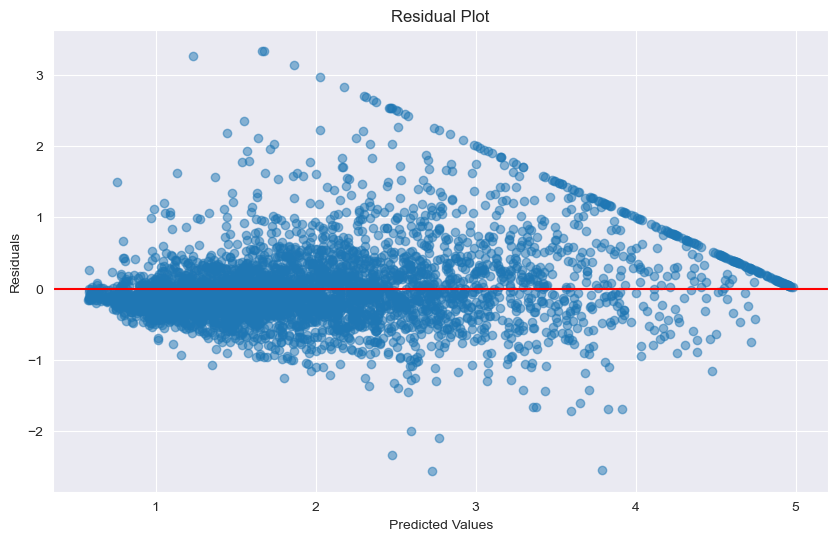

In [15]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

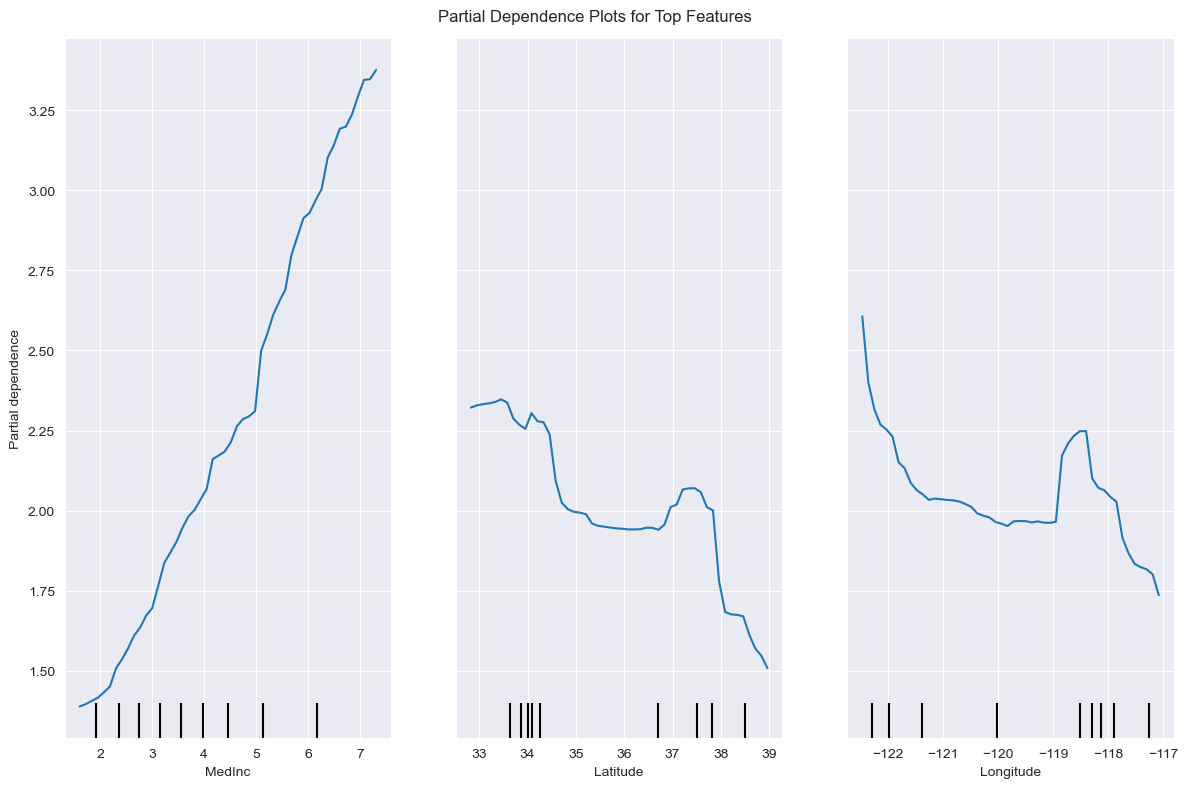

In [17]:
# For top 3 important features
top_features = X.columns[indices][:3]

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    rf, X_train, top_features,
    n_jobs=-1, grid_resolution=50, ax=ax
)
plt.suptitle('Partial Dependence Plots for Top Features')
plt.tight_layout()
plt.show()

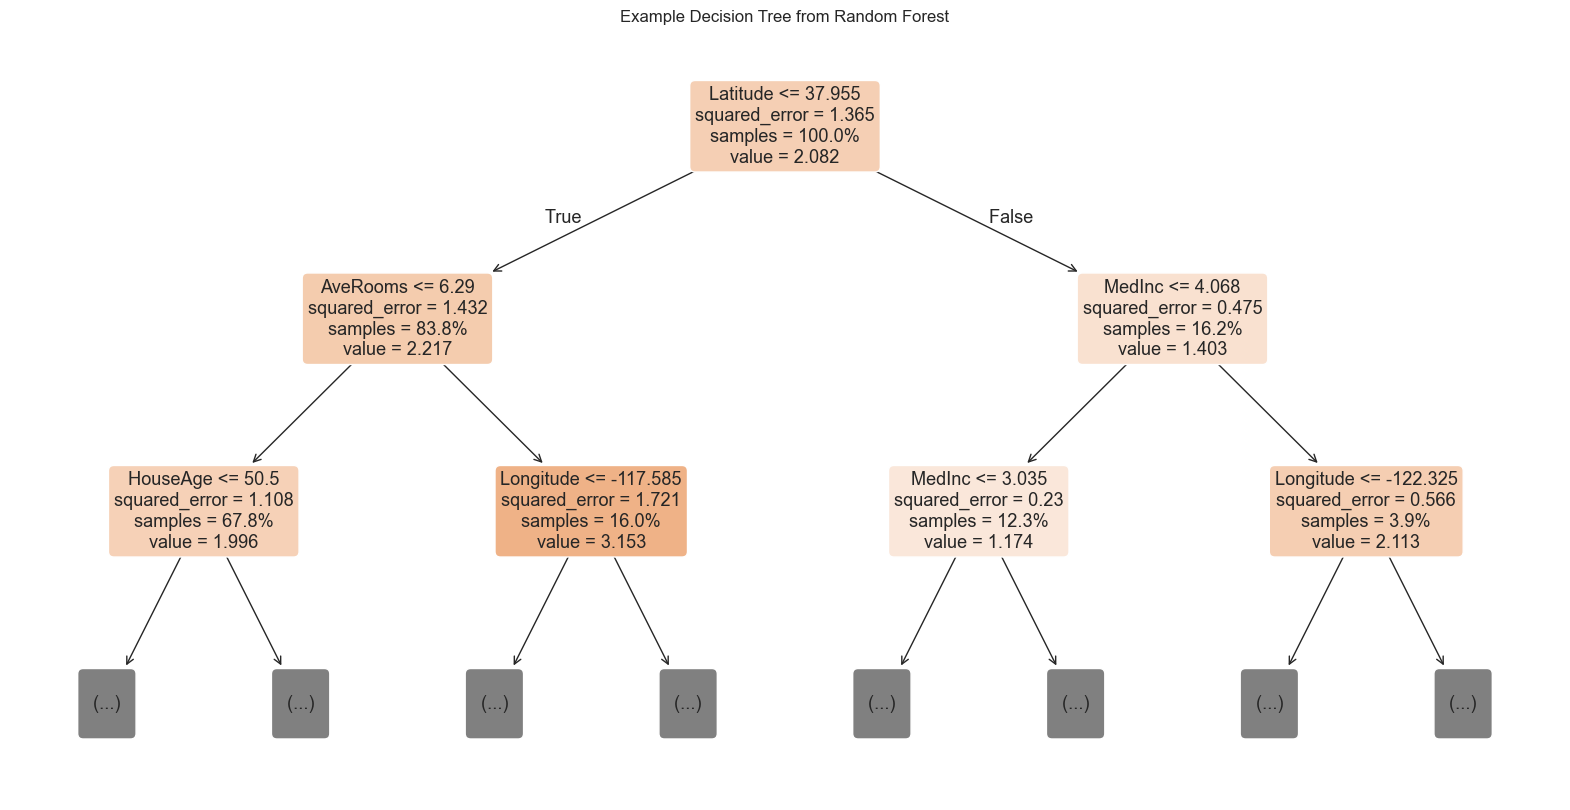

In [19]:
# Visualize one of the trees in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0],
          feature_names=X.columns,
          filled=True,
          rounded=True,
          max_depth=2,
          proportion=True)
plt.title("Example Decision Tree from Random Forest")
plt.show()

In [21]:
# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [22]:
# Random search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [23]:
# Execute search
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=12,
                                                   max_features='sqrt',
                                                   min_samples_leaf=2,
                                                   min_samples_split=5,
                                                   n_estimators=200, n_jobs=-1,
                                                   random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [24]:
# Best parameters
print("\nBest Parameters:", rf_random.best_params_)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [27]:
# Initialize and train model with best parameters
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)

In [28]:
# Fit best model
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_features='log2', n_estimators=200, n_jobs=-1,
                      random_state=42)

In [29]:
# Make predictions
y_pred = best_rf.predict(X_test)
y_train_pred = best_rf.predict(X_train)

In [30]:
# Evaluate model performance
print("\n=== Best Model Evaluation ===")
print(f"Training R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred):.4f}")
print(f"Test RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)) * 100000:.2f}")


=== Best Model Evaluation ===
Training R²: 0.9755
Test R²: 0.8136
Test RMSE: $49420.32


In [31]:
# Feature Importance Analysis (Updated)
importances = best_rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

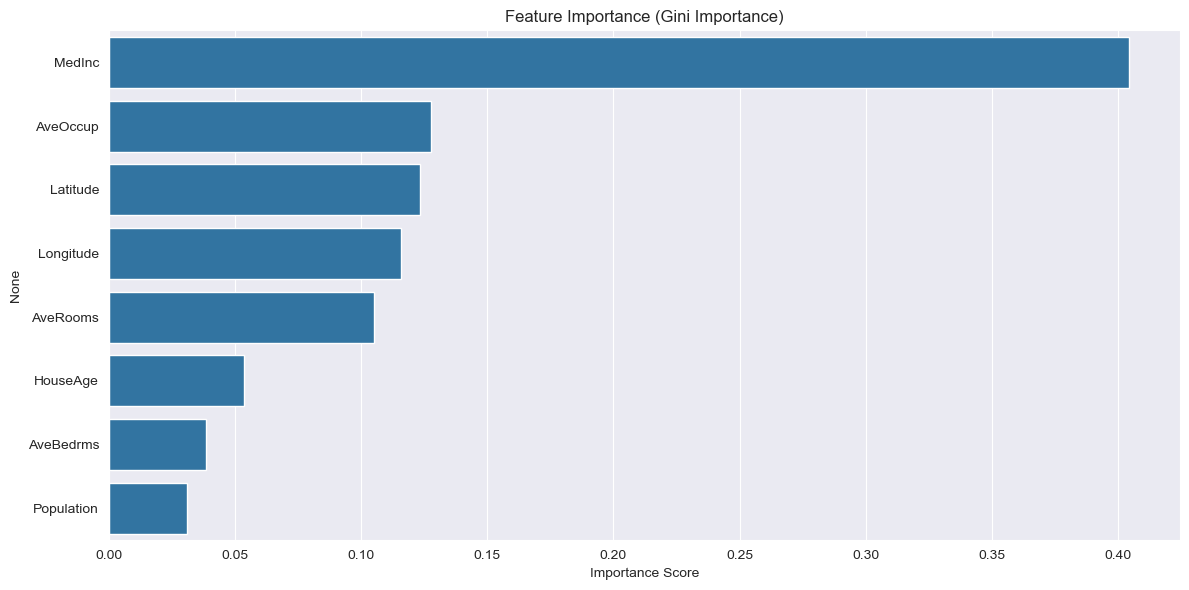

In [32]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx])
plt.title("Feature Importance (Gini Importance)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

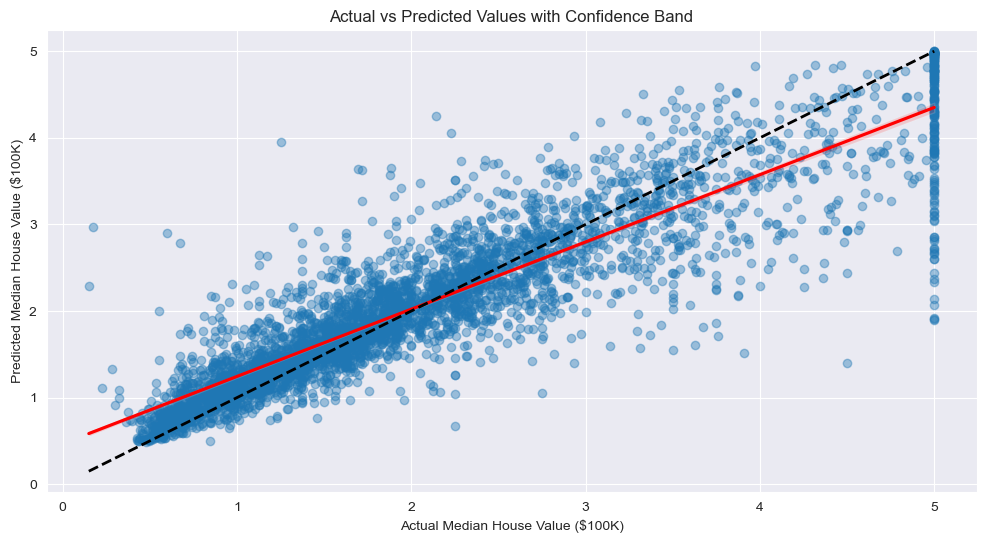

In [33]:
# Enhanced Prediction Visualization
plt.figure(figsize=(12, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Median House Value ($100K)")
plt.ylabel("Predicted Median House Value ($100K)")
plt.title("Actual vs Predicted Values with Confidence Band")
plt.show()

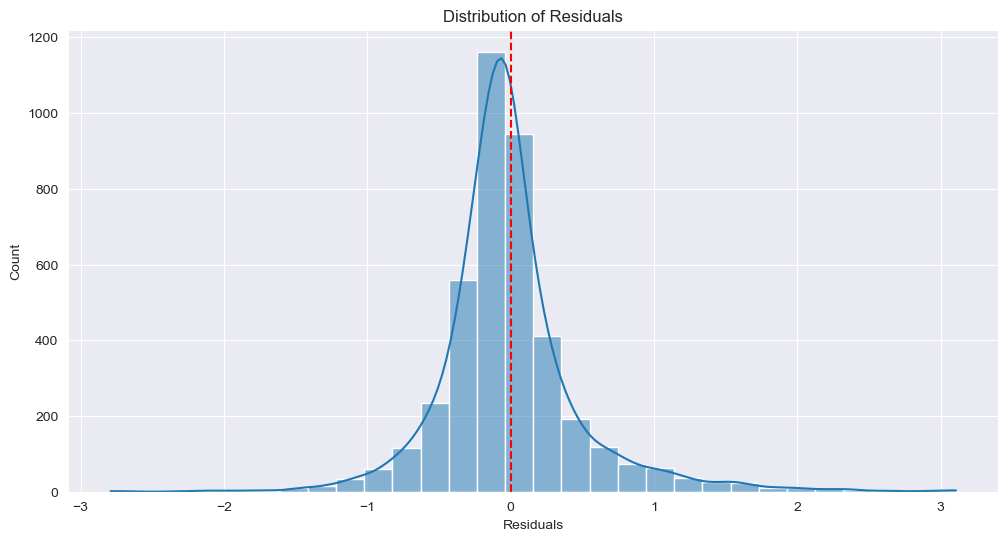

In [34]:
# Enhanced Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

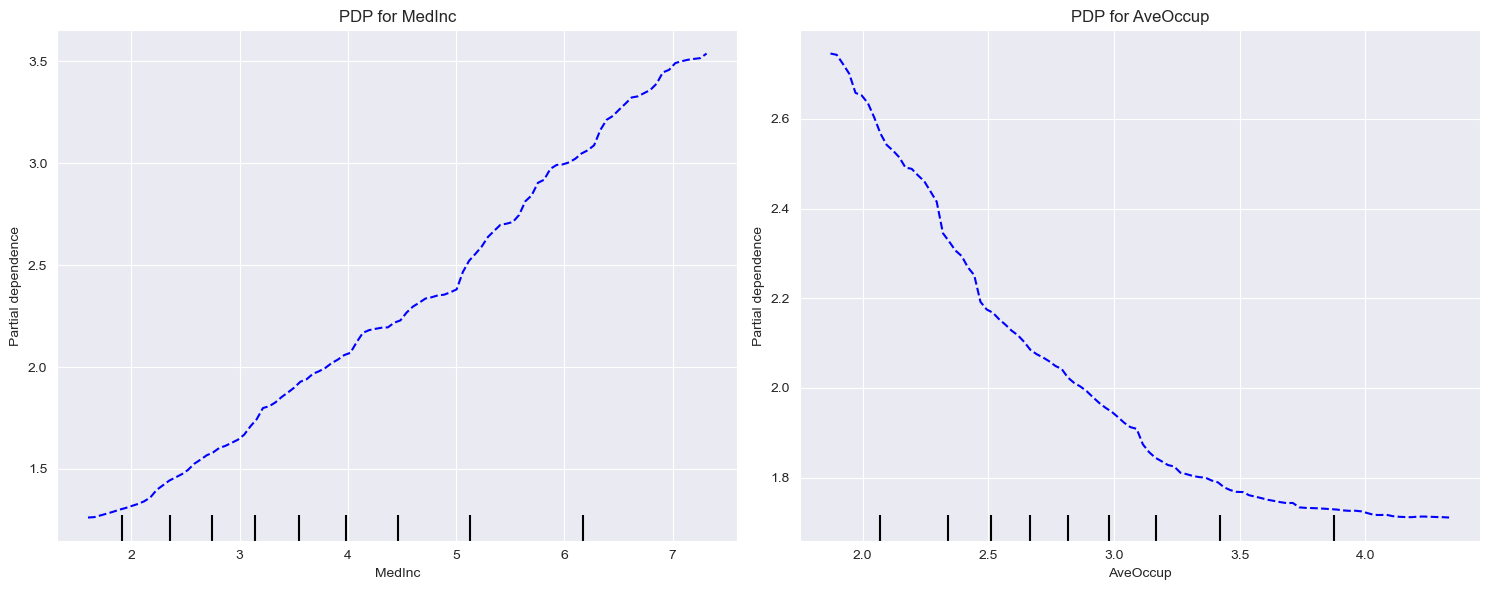

In [35]:
# Partial Dependence for Top 2 Features
top_features = X.columns[sorted_idx][:2]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for i, feature in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(
        best_rf, X_train, [feature],
        ax=ax[i],
        line_kw={"color": "red"},
        pd_line_kw={"color": "blue", "linestyle": "--"}
    )
    ax[i].set_title(f"PDP for {feature}")
plt.tight_layout()
plt.show()

In [ ]:
# SHAP Force Plot for Specific Example
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Plot for first observation
plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.title("SHAP Explanation for First Test Observation")
plt.tight_layout()
plt.show()